<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Detec%C3%A7%C3%A3o_de_posi%C3%A7%C3%A3o_f%C3%ADsica_humana_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset"
#/content/gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/val/sitting
#/content/gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode



In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Neptune config

In [6]:
! pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.9 MB/s eta 0:00:00


In [9]:
import neptune.new as neptune
from neptune.types import File
import pickle

def neptune_start_ID(with_id='Default'):
    run = neptune.init_run (project= 'octavioguaschi/IA901-218390',#"breno/IA901-2023S1",#
                       with_id=with_id,
                       #custom_run_id=name,
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")
    return run

#/content/gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/interim
def neptune_download_pickle():
    run["model/pickled_model"].download(destination="./model.pkl")
    file = open("/content/model.pkl",'rb')
    model = pickle.load(file)
    return model

In [ ]:
#temos que resgatar o ID do Neptune para saber qual pickle baixar.

run = neptune.init_run (project='octavioguaschi/IA901-218390',
                        with_id="IA90-79",
                        #custom_run_id=name,
                        #tags=[model.name,'Segmento1', 'tags', 'vocab_size_2000', 'as-list-of-strings'],
                        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")



run["model/pickled_model"].download(destination="./model.pkl")


In [29]:
#https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-148
run = neptune_start_ID("IA90-148")
print(run["sys/id"].fetch())
model = neptune_download_pickle()

https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-148
IA90-148


# Dataset Loader


In [13]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [17]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
print(dataset_sizes)

{'train': 2169, 'val': 724, 'test': 723}


Batch of training data


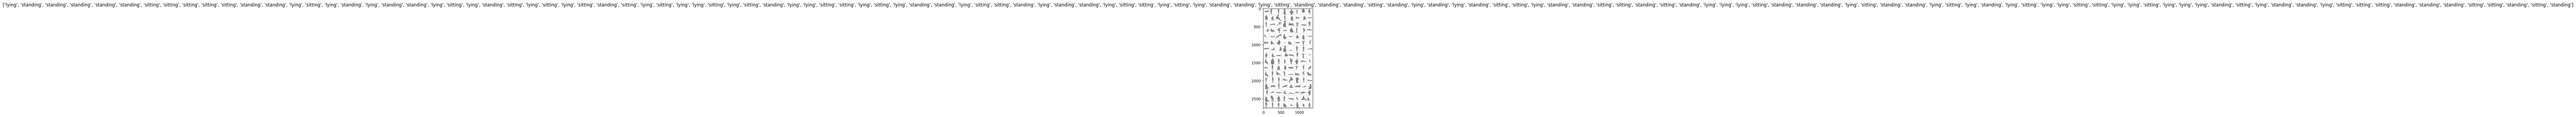

Batch of validation data


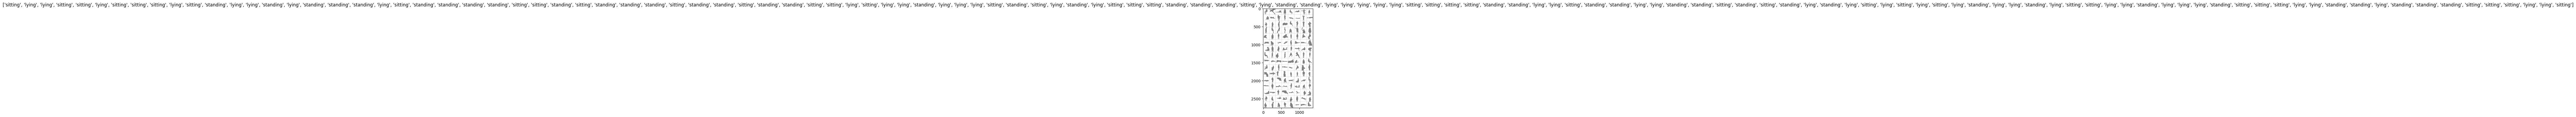

Batch of test data


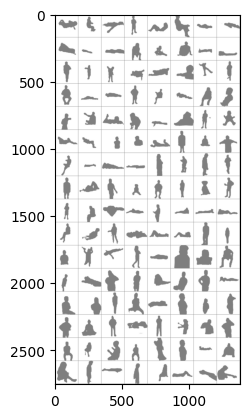

('gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/839.jpg', 'gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/sitting/410.jpg', 'gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/1067.jpg', 'gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/standing/1163.jpg', 'gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/258.jpg', 'gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/sitting/712.jpg', 'gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/917.jpg', 'gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/

In [19]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

# Testing Model

In [33]:

certos = 0
errados = 0
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    certos = 0
    errados = 0

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if(paths[j].split('/')[7] != class_names[preds[j]]):
                  images_so_far += 1
                  errados += 1
                  fig = plt.figure(figsize=(50, 50))
                  plt.tight_layout()
                  plt.subplot(num_images, 1, images_so_far)
                  plt.axis('off')
                  print('path: {} / predicted: {}'.format(paths[j].split('/')[9], class_names[preds[j]]))
                  run['test/predicted'].append('path: {} / predicted: {}'.format(paths[j].split('/')[9], class_names[preds[j]]))
                  imshow(inputs.cpu().data[j])
                else:
                  certos +=1
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print('Test Acc: {:4f}'.format(certos/(certos+errados)))
                    run['test/acc'].append(certos/(certos+errados))
                    return
        model.train(mode=was_training)

path: sitting / predicted: sitting


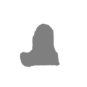

path: lying / predicted: lying


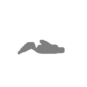

path: lying / predicted: lying


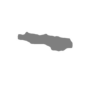

path: sitting / predicted: standing


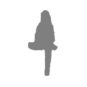

path: sitting / predicted: sitting


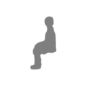

path: sitting / predicted: sitting


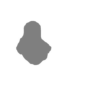

path: lying / predicted: lying


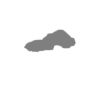

path: standing / predicted: standing


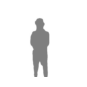

path: standing / predicted: standing


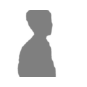

path: standing / predicted: standing


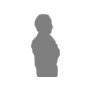

path: sitting / predicted: sitting


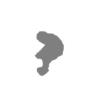

path: standing / predicted: standing


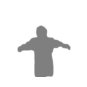

path: lying / predicted: lying


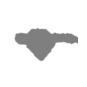

path: sitting / predicted: sitting


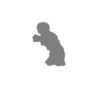

path: standing / predicted: standing


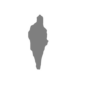

path: lying / predicted: lying


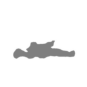

path: standing / predicted: standing


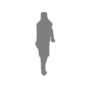

path: standing / predicted: standing


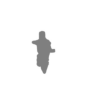

path: lying / predicted: lying


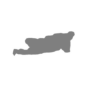

path: sitting / predicted: sitting


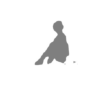

path: lying / predicted: sitting


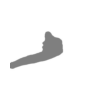

path: standing / predicted: standing


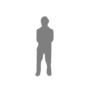

path: sitting / predicted: sitting


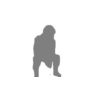

path: sitting / predicted: lying


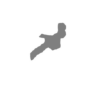

path: standing / predicted: standing


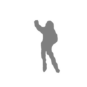

path: lying / predicted: standing


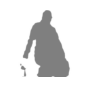

path: standing / predicted: standing


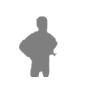

path: sitting / predicted: sitting


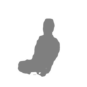

path: sitting / predicted: sitting


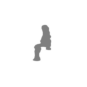

path: sitting / predicted: sitting


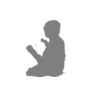

path: standing / predicted: standing


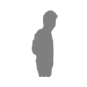

path: sitting / predicted: sitting


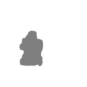

path: lying / predicted: lying


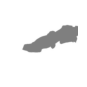

path: lying / predicted: lying


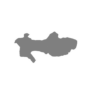

path: sitting / predicted: sitting


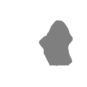

path: sitting / predicted: sitting


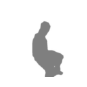

path: sitting / predicted: sitting


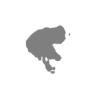

path: sitting / predicted: standing


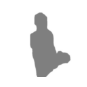

path: standing / predicted: standing


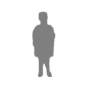

path: sitting / predicted: sitting


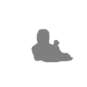

path: sitting / predicted: sitting


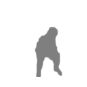

path: standing / predicted: standing


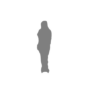

path: lying / predicted: lying


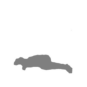

path: standing / predicted: standing


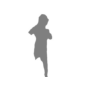

path: lying / predicted: lying


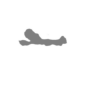

path: standing / predicted: standing


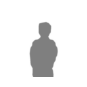

path: standing / predicted: standing


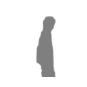

path: sitting / predicted: sitting


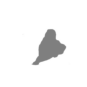

Test Acc: 0.000000


In [32]:
#print(object_file == model_ft_randstart)
# True
#print(object_file is model_ft_randstart)
# False
test_model(model)
#test_model(model_ft_randstart)
